# Deep Learning : Soundnet  
# Notebook of Jean Plumail & Lucas Rakotoarivony

Useful Link :
- https://github.com/SunnerLi/SoundNet_Pytorch
- http://soundnet.csail.mit.edu/
- https://github.com/EsamGhaleb/soundNet_pytorch
- https://github.com/jplumail/SoundNet
- https://github.com/karolpiczak/ESC-50

# 0) Explanation of how Soundnet works

Soundnet works according to the principle of student teacher.  
We use videos to train SoundNet. From these videos we extract the images we send in two CNN (Image Net CNN and Places CNN). These two CNN are the teachers who have already been trained. We get an Object Distribution and a Scene distribution from these two CNN.  
On the other hand we are gonna extract the sound from that same video we’re gonna send to Soundnet. From Soundnet we will also get a Scene and an Object Distribution.  
The goal is to minimize KL Loss by using backpropagation and both distributions.

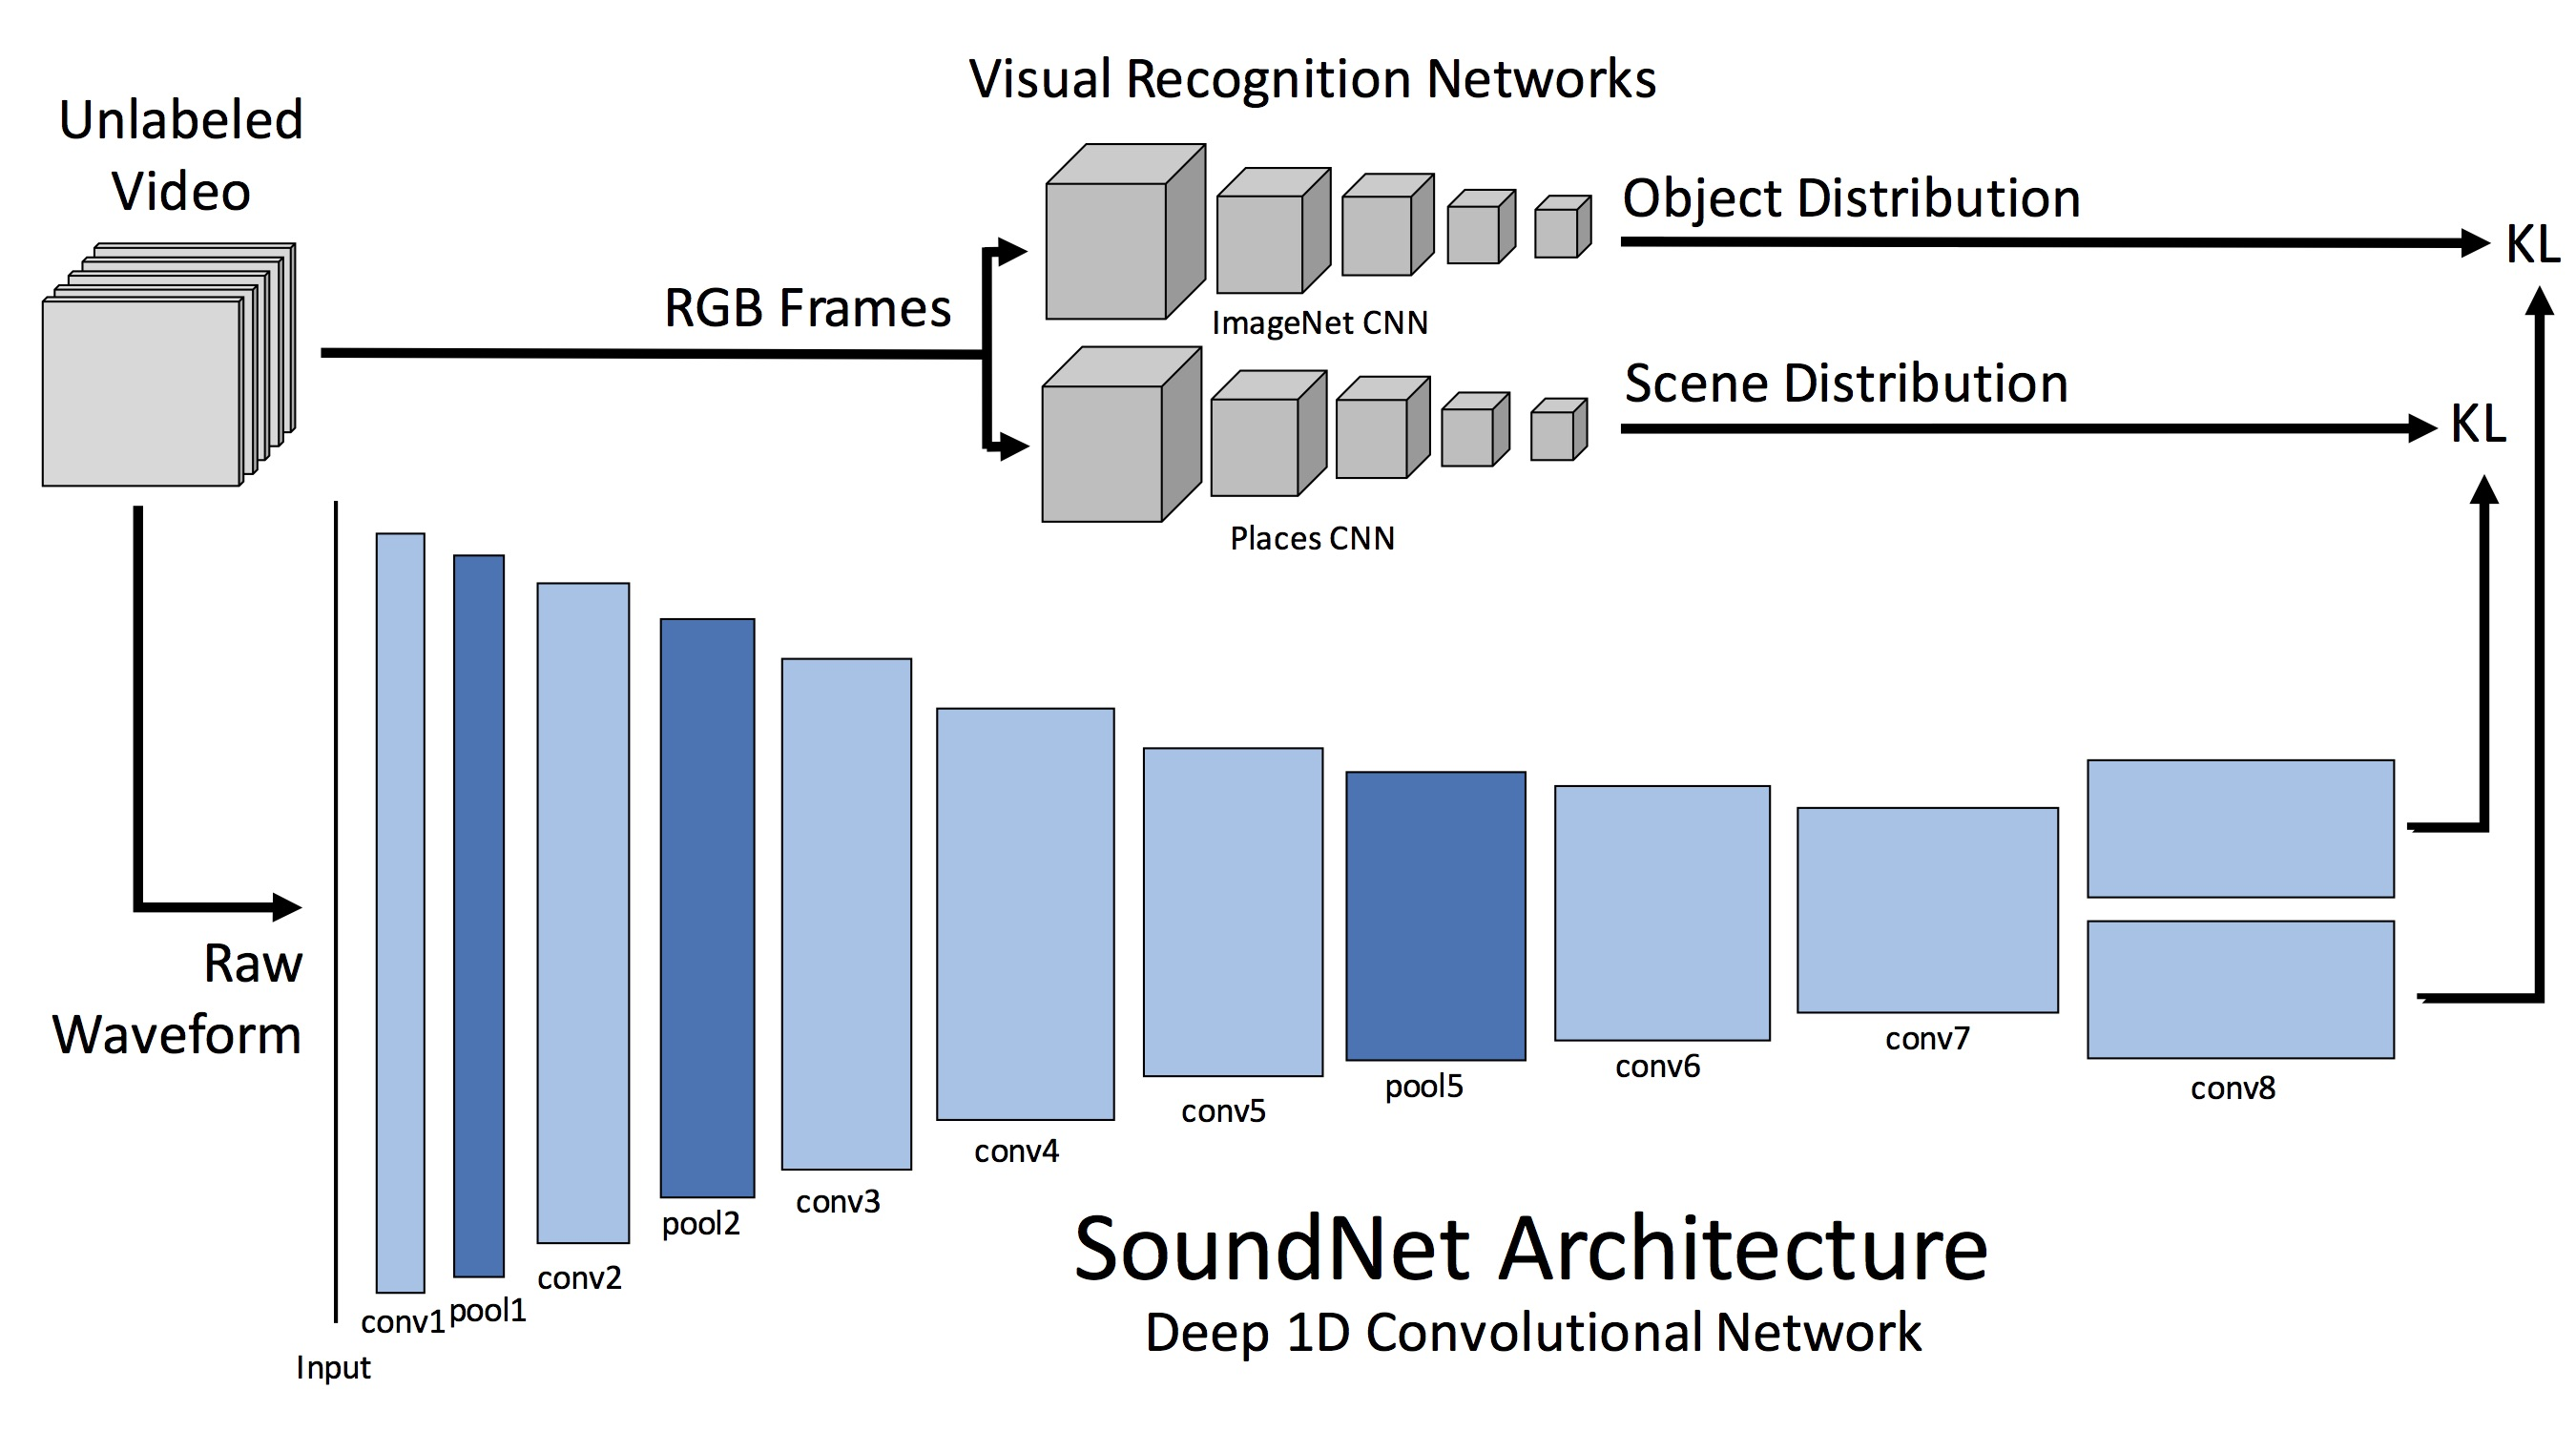

The loss is a __KL loss__ (for *Kullback-Leibler Divergence*) which is defined by : 
$$\text{KL}(P,Q) = - \sum_{x \in X} P(x) \times \log(\frac{Q(x)}{P(x)})$$  
This loss is special because it measures how one probability distribution is different from a second.   
This loss is interesting in this case because it can effectively compare two distributions.  
Note that they also tried other loss function like the l2 loss but the results were less good.  
The objective of Soundnet is therefore to replicate the distributions of Places CNN and Image Net CNN.

It is also important to note the importance of the different intermediate outputs.
In fact, for the purpose of classification we use intermediate output and in particular the output of conv 5 (we will explain this in more detail in part 2).

# 1) Data Import

In this part we will extract the data that will be necessary for our studies.  

In [ ]:
!pip install datashader
from google.colab import output
import umap
import umap.plot
!wget https://raw.githubusercontent.com/jplumail/SoundNet/master/real_util.py
!wget https://github.com/SunnerLi/SoundNet_Pytorch/raw/master/sound8.pth
from real_util import *
output.clear()

If you don’t want to waste time and get back the data we recovered and uploaded to our git, use this cell.

In [ ]:
!wget https://github.com/jplumail/SoundNet/raw/master/donnee_ESC/X.npy
!wget https://github.com/jplumail/SoundNet/raw/master/donnee_ESC/X_out_1.npy
!wget https://github.com/jplumail/SoundNet/raw/master/donnee_ESC/X_out_2.npy
!wget https://github.com/jplumail/SoundNet/raw/master/donnee_ESC/X_out_3.npy
!wget https://github.com/jplumail/SoundNet/raw/master/donnee_ESC/X_out_4.npy
!wget https://github.com/jplumail/SoundNet/raw/master/donnee_ESC/X_out_6.npy
!wget https://github.com/jplumail/SoundNet/raw/master/donnee_ESC/X_out_7.npy
!wget https://github.com/jplumail/SoundNet/raw/master/donnee_ESC/y.npy

X = np.load("X.npy")
X_out_1 = np.load("X_out_1.npy")
X_out_2 = np.load("X_out_2.npy")
X_out_3 = np.load("X_out_3.npy")
X_out_4 = np.load("X_out_4.npy")
X_out_6 = np.load("X_out_6.npy")
X_out_7 = np.load("X_out_7.npy")
y = np.load("y.npy")
output.clear()

If you prefer to recreate the data, run the next two cells.  
Careful this cell takes about 15-20 minutes to run and the results will be the same as with the previous method.

In [ ]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip
!wget https://github.com/SunnerLi/SoundNet_Pytorch/raw/master/sound8.pth
output.clear()

In [ ]:
creation_data()
sound_samples, audio_paths = load_data()
X,X_out_1,X_out_2,X_out_3,X_out_4,X_out_6,X_out_7,y = extract_complete(sound_samples, audio_paths, model)

Data formatting (to be performed in both cases)

In [ ]:
X_animals,y_animals,y_labels_animals,X_natural,y_natural,y_labels_natural,X_human,y_human,y_labels_human,X_interior,y_interior,y_labels_interior,X_exterior,y_exterior,y_labels_exterior = five_major_class(X,y,labels_complet)
X_difficult,y_difficult,y_labels_difficult,X_simple,y_simple,y_labels_simple = easy_difficult(X,y,labels_complet)

X_tronque = X[:1200]
y_tronque = y[:1200]

y_reduct=[]
for i in y_tronque:
  y_reduct.append(label[i//10])

if __name__ == '__main__':
    model = SoundNet()
    model.load_state_dict(torch.load('sound8.pth'))

# 2) Transfert Learning

In this part we will perform Transfert Learning from the SoundNet model output 5.  
We will then use the result of this output to train an SVM on the ESC-50 database.  
We chose this output because it is the one that gives the best results according to the Soundnet study.

It is important to note that the different Soundnet outputs retain the time dimension.  
At first we just flattened the data using the reshape(-1) function. In this case we obtained a result of 0.63 in cross validation which is quite far from the expected result (0.75).  
Following Mr Farrugia’s advice, we decided to remove the time dimension by averaging time.  
This greatly improved our results (0.63 to 0.72) while significantly improving the calculation speed, indeed by doing so we greatly reduced the size of our features.

In [ ]:
custom_cv=custom_cv_5folds(X)
scaler = StandardScaler()
SVM = svm.LinearSVC(max_iter=10000)
pipe = Pipeline(steps=[('scaler', scaler), ('SVM', SVM)])

param_grid = {
    'SVM__C': np.logspace(-4, 1, 6),

}

search = GridSearchCV(pipe, param_grid, cv = custom_cv)
search.fit(X, y)
print(search.cv_results_)
print(search.best_score_)
print(search.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

{'mean_fit_time': array([ 1.95906124, 12.69617867, 22.55324688,  9.36251879, 13.70974183,
       22.78525124]), 'std_fit_time': array([0.28987942, 3.16025741, 3.25032525, 0.89317654, 0.5233843 ,
       0.18380359]), 'mean_score_time': array([0.00280099, 0.00297909, 0.00304327, 0.00285068, 0.00330482,
       0.00355353]), 'std_score_time': array([3.76793090e-05, 1.56225156e-04, 3.41171592e-04, 8.16777095e-05,
       5.71046245e-04, 4.64696260e-04]), 'param_SVM__C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'SVM__C': 0.0001}, {'SVM__C': 0.001}, {'SVM__C': 0.01}, {'SVM__C': 0.1}, {'SVM__C': 1.0}, {'SVM__C': 10.0}], 'split0_test_score': array([0.5575, 0.66  , 0.725 , 0.7325, 0.6675, 0.63  ]), 'split1_test_score': array([0.5825, 0.6125, 0.69  , 0.7   , 0.6575, 0.625 ]), 'split2_test_score': array([0.5825, 0.665 , 0.7175, 0.725 , 0.6675, 0.625 ]), 'split3

We performed a GridSearch to find the optimal value of C in our case.   
It is also important to note that we also tried to vary other parameters like gamma or kernel however this did not increase our results.

In [ ]:
custom_cv=custom_cv_5folds(X)
clf = make_pipeline(StandardScaler(), svm.LinearSVC(C=0.1,max_iter=10000))
scores = cross_val_score(clf, X, y, cv=custom_cv)
print(f'Score obtenu en Cross validation avec les meilleurs paramètres: {scores.mean():0.2f}')

Score obtenu en Cross validation avec les meilleurs paramètres: 0.72


We see that we get a score of 0.72 on a cross validation on the 5 official folds of ESC-50. This is very similar to the results obtained by researchers working on SoundNet( 0.75). This slight difference can be explained by the fact that we did not use Data Augmentation to train our SVM.

# 3) Visualization of the Data

In this part we will visualize the Soundnet outputs in 2 dimensions using Umap according to several factors in order to better understand the differences between the Soundnet outputs.

We chose to view all outputs. However for reasons of size we decided to keep only the first 3 folds for each output.

In [ ]:
def umap_visualisation(X,y,label,title):
  mapper_out_1 = umap.UMAP(metric='cosine').fit(X,y)
  umap.plot.points(mapper_out_1,labels=np.asarray(label))
  plt.title(title,fontsize=20)

We chose to display the labels under the 5 main classes of the ESC-50 (Animals, Natural soundscapes & water sounds, Human non-speech sounds,Interior/domestic sounds, Exterior/urban noises. Indeed with the 50 classes it is impossible to understand the results visually.

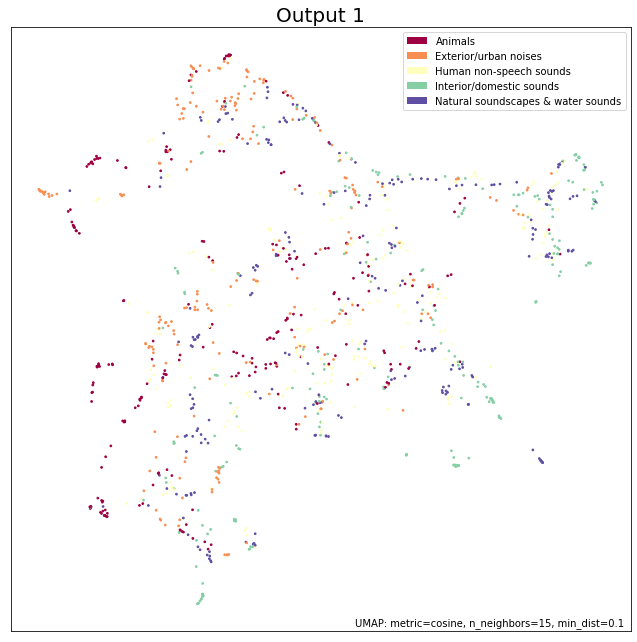

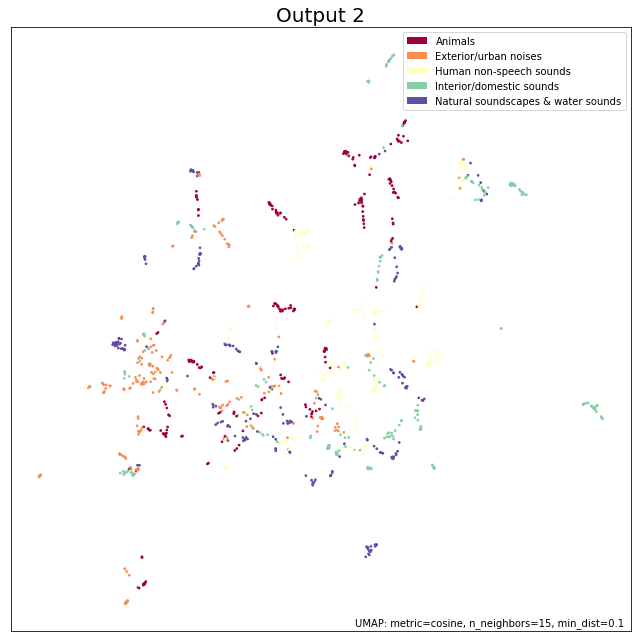

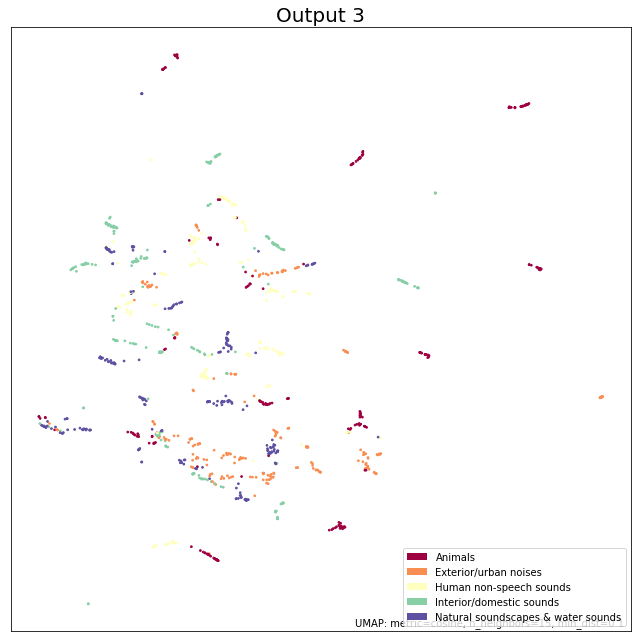

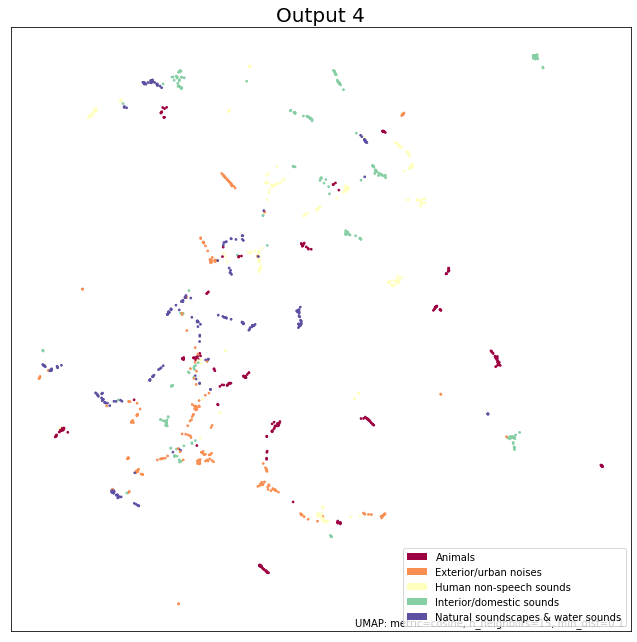

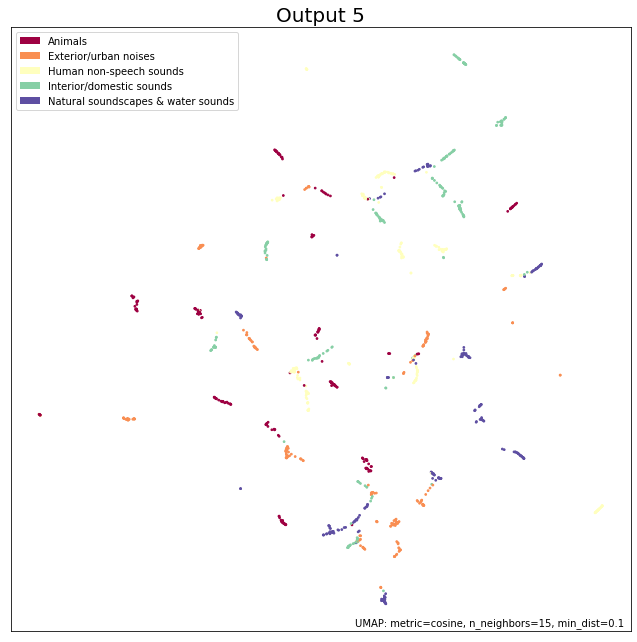

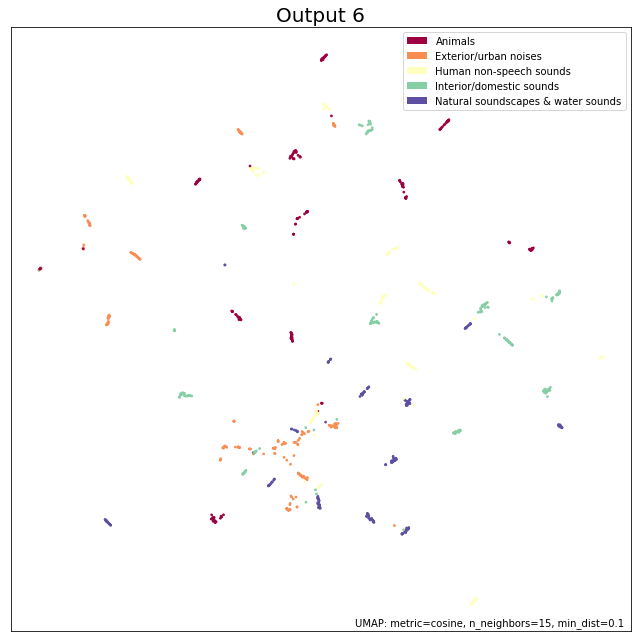

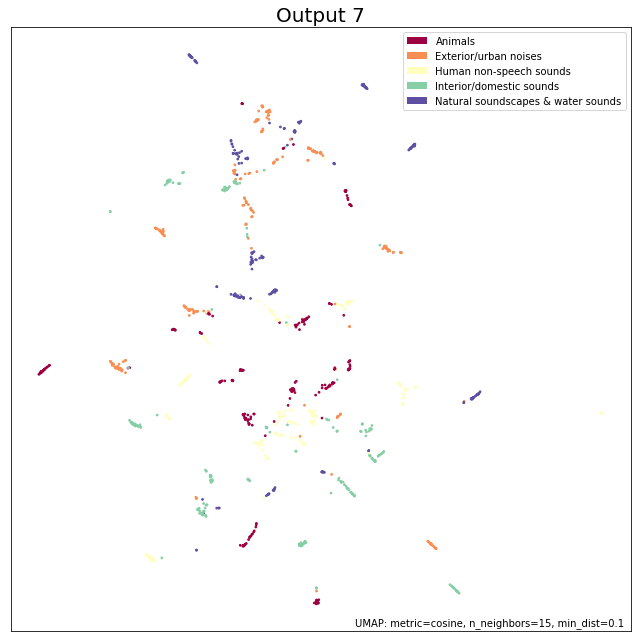

In [ ]:
umap_visualisation(X_out_1,y_tronque,y_reduct,"Output 1")
umap_visualisation(X_out_2,y_tronque,y_reduct,"Output 2")
umap_visualisation(X_out_3,y_tronque,y_reduct,"Output 3")
umap_visualisation(X_out_4,y_tronque,y_reduct,"Output 4")
umap_visualisation(X_tronque,y_tronque,y_reduct,"Output 5")
umap_visualisation(X_out_6,y_tronque,y_reduct,"Output 6")
umap_visualisation(X_out_7,y_tronque,y_reduct,"Output 7")

First of all we notice that in all outputs it is very difficult to distinguish clusters corresponding to the 5 major classes. This makes sense because each large class contains 10 distinct classes and these classes are sometimes very distinct from each other (a dog and an insect are considered as animals but their sound is very different).
Then we notice that for outputs 1 and 2, the data are not distinguishable from each other (no appearance of mini cluster).  
However looking at outputs 3,4,5 and 6 we observe the appearance of mini clusters of the same color corresponding surely to the different subclasses. It can be noted that output 5 gives a clearer separation which explains why we use this output to obtain the best results in learning transfer.
Output 7 surprisingly gives worse results than previous outputs even if it remains more efficient than outputs 1 and 2.

We will now focus on output 5 (because it is the one that gives the best results) to observe the different subclasses of the main classes.

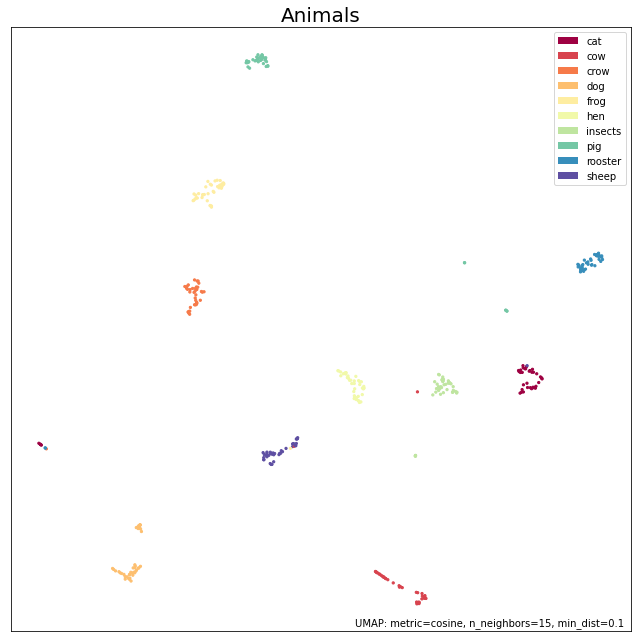

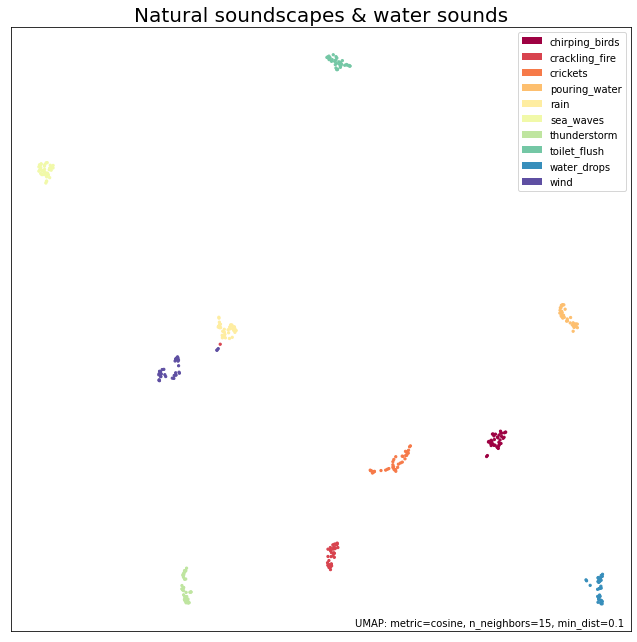

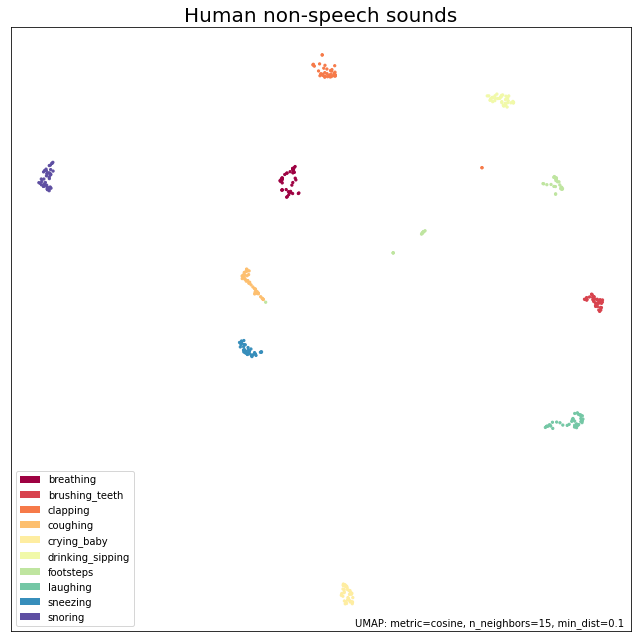

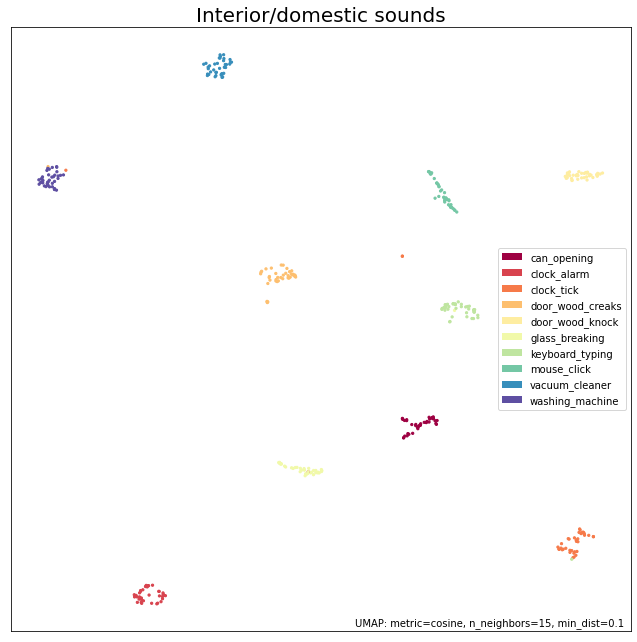

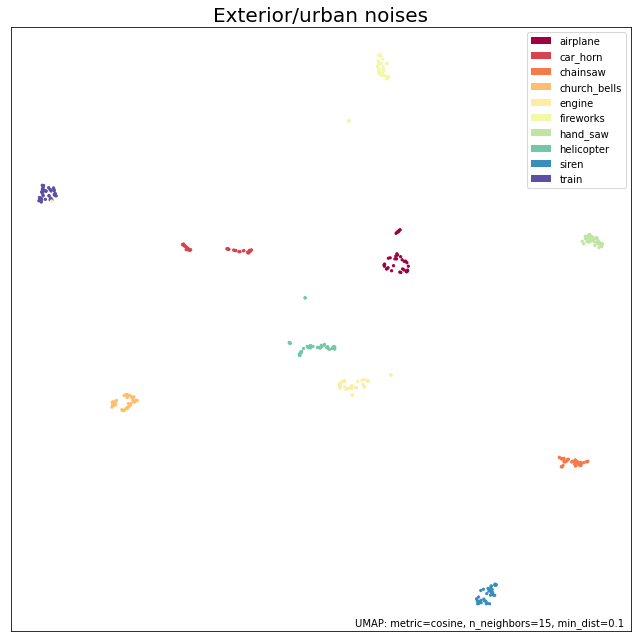

In [ ]:
umap_visualisation(X_animals,y_animals,y_labels_animals,"Animals")
umap_visualisation(X_natural,y_natural,y_labels_natural,"Natural soundscapes & water sounds")
umap_visualisation(X_human,y_human,y_labels_human,"Human non-speech sounds")
umap_visualisation(X_interior,y_interior,y_labels_interior,"Interior/domestic sounds")
umap_visualisation(X_exterior,y_exterior,y_labels_exterior,"Exterior/urban noises")

It is noted that all subclasses are easily distinguishable from each other. This confirms our good results obtained during cross validation.
However we observe that sometimes some points are not found in their cluster or even in a different cluster. We will now focus on the classes that are confused with the others using the confusion matrix.

normalized confusion matrix


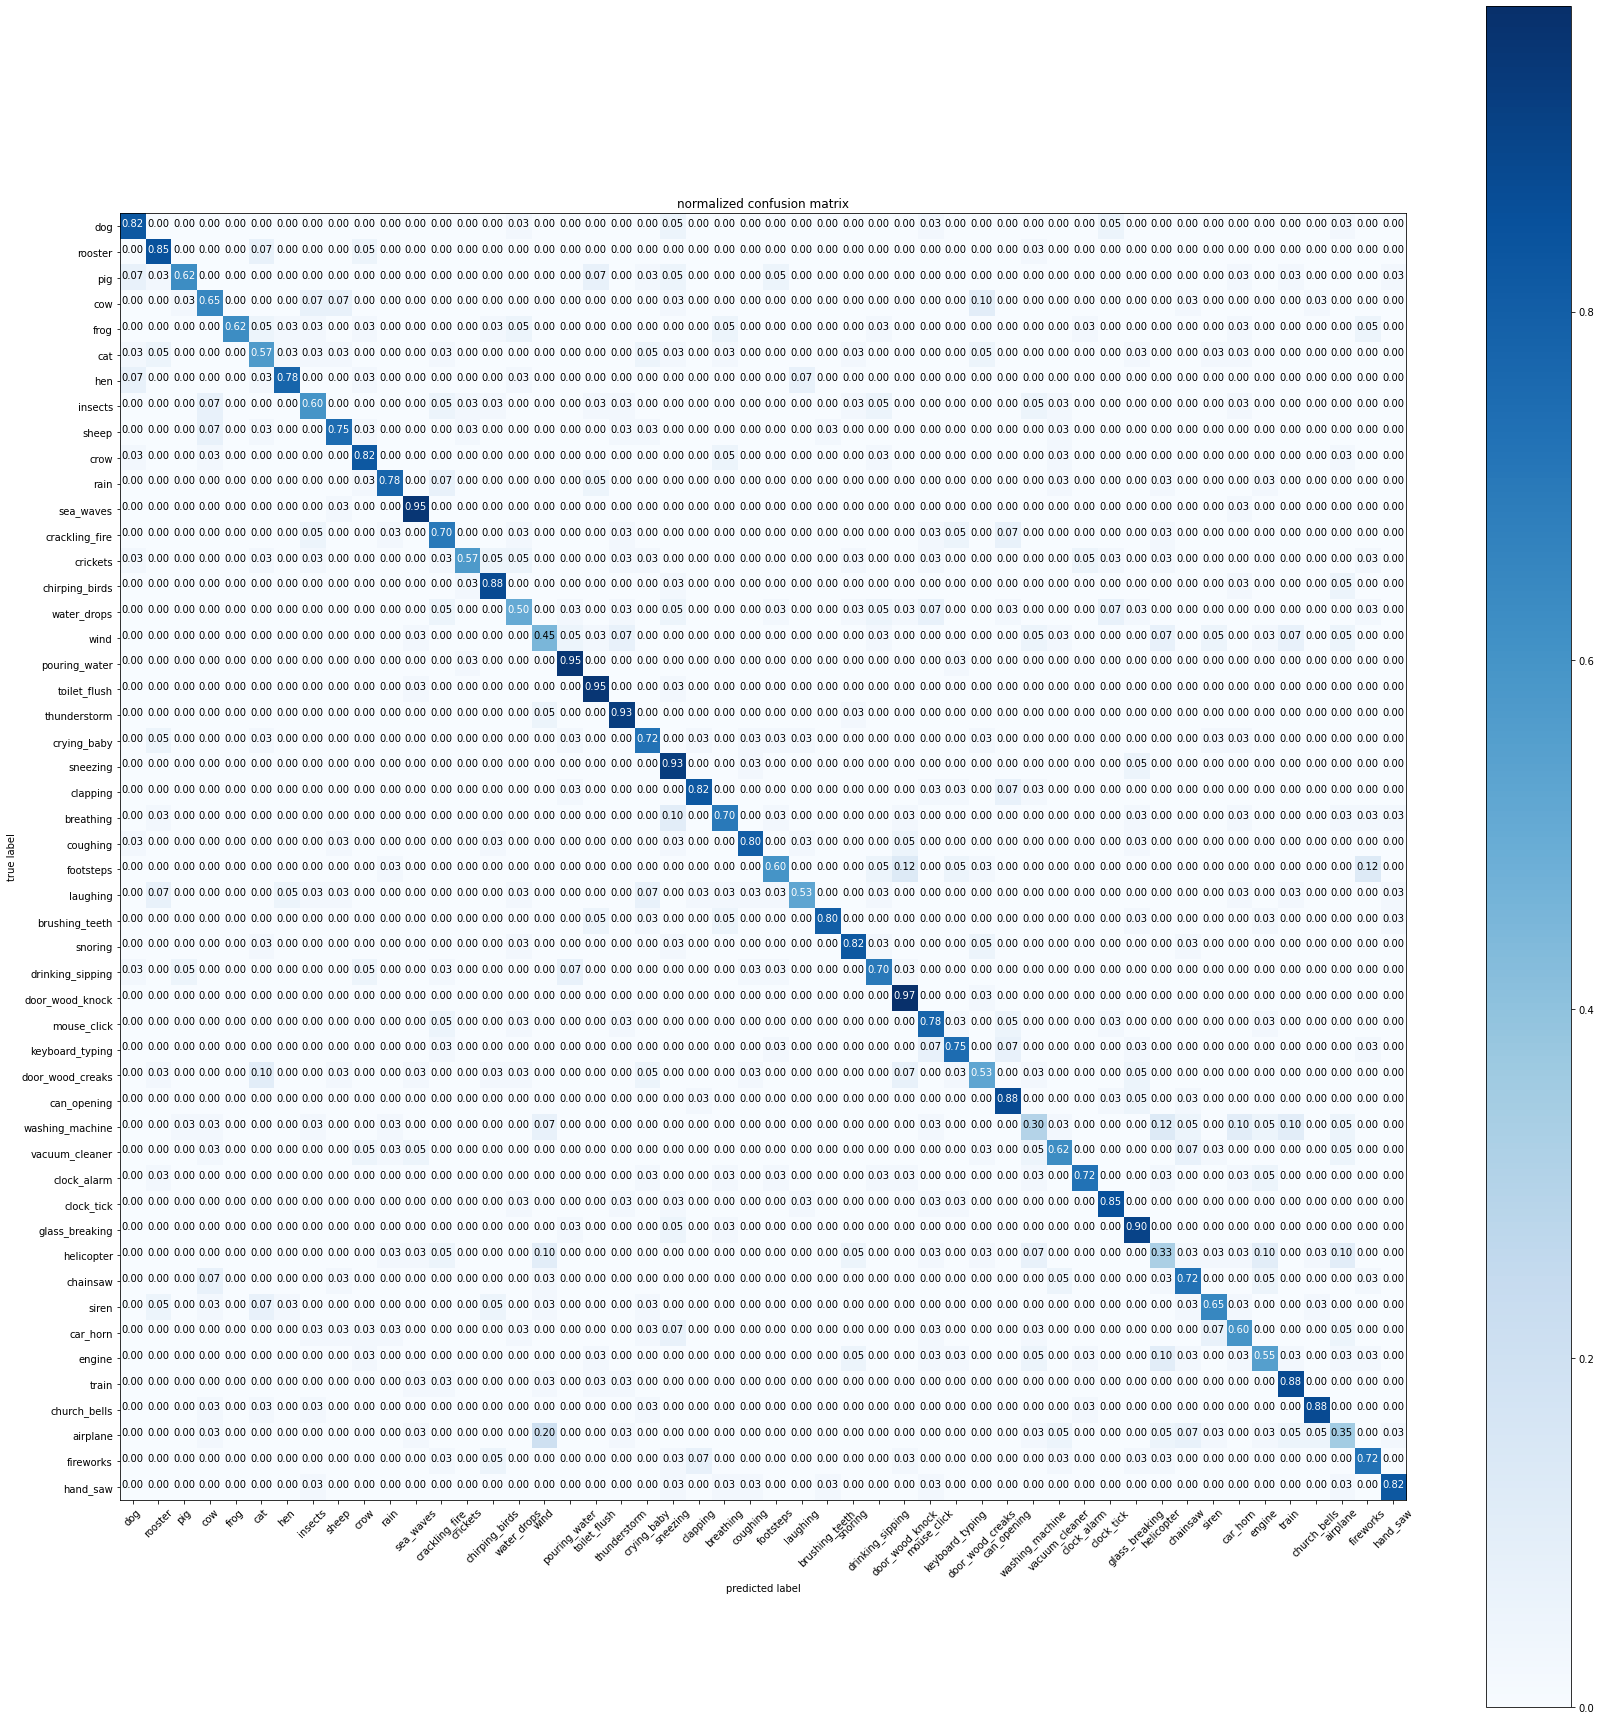

In [ ]:
# compute confusion matrix
cnf_matrix = np.zeros((50,50))
i = 0
while i < 5:
  X_train = np.concatenate((X[0:i*400],X[(i+1)*400:2000]))
  y_train = np.concatenate((y[0:i*400],y[(i+1)*400:2000]))
  X_test = X[i*400:(i+1)*400]
  y_test = y[i*400:(i+1)*400]
  clf = make_pipeline(StandardScaler(), svm.LinearSVC(C=0.1,max_iter=10000))
  clf.fit(X_train,y_train)
  cnf_matrix = cnf_matrix + confusion_matrix(y_test, clf.predict(X_test))
  i += 1
np.set_printoptions(precision=2)

#class_names = range(50)
class_names = []
for i in range(50):
  class_names.append(labels_complet[i])
# plot normalized confusion matrix
plt.figure(figsize=(24, 24))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='normalized confusion matrix')

plt.show()

Using this matrix of confusion we observe that some classes are particularly difficult to predict and other are particularly easy.  
We will now see if there are significant visual differences between easy and difficult to predict classes.

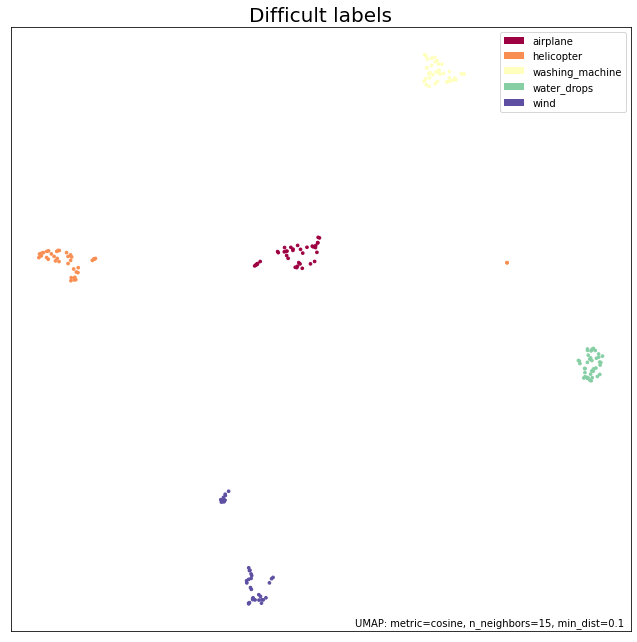

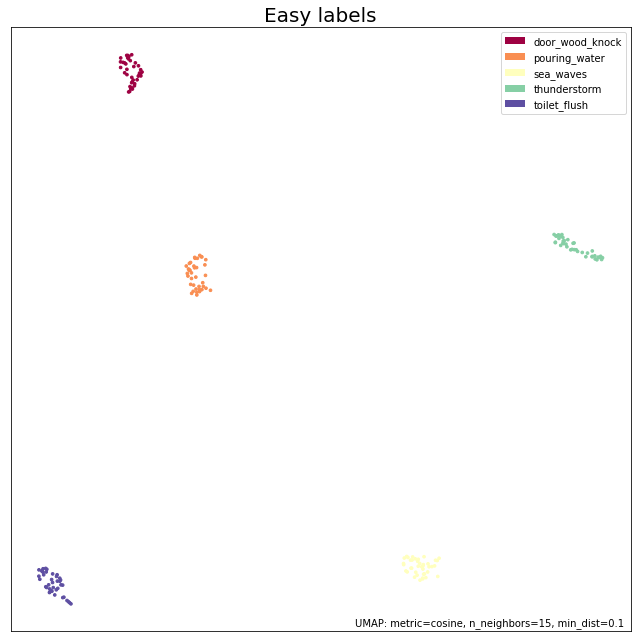

In [ ]:
umap_visualisation(X_difficult,y_difficult,y_labels_difficult,"Difficult labels")
umap_visualisation(X_simple,y_simple,y_labels_simple,"Easy labels")

Immediately we can notice that the clusters of the classes difficult to predict are less dense than those of the easy classes.  
However this difference is slight and taking for example the class water drops which is a difficult class we notice that this class was easy to clusterize.  
This is partly because Umap uses all the data to fit, unlike our SVM which uses a test set.  
This shows us that a visualization method such as Umap is very interesting to better understand the data but that this is not enough to perform a precise classification.  
For example, if we had no knowledge on Soundnet it could have allowed us to know which output is the most interesting to carry out the learning transfer.

# 4) Partie de Pluplu